In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Introduction

The ultimate goal of this project is to analyze the current state of music and potentially predict the future state of music so that our music partnerships can generate new ideas for their artists.

We'll want to uncover patterns in the Global top 50, construct insights and recommend actions the our partners should do next.

# Data Collection

In [260]:
#I deleted the Spotipy code that shows the playlist data being 
#imported because it includes my client code and client secret

# Data Preprocessing

In [124]:
df = pd.DataFrame(audio_features_list)

df['track_name'] = [track['track']['name'] for track in results['items']]

In [125]:
missing_values = df.isnull().sum()
missing_values

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
track_name          0
dtype: int64

In [126]:
columns_to_drop = ['type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'id']
df = df.drop(columns = columns_to_drop)

In [127]:
cols = ['track_name'] + [col for col in df if col != 'track_name']
df = df[cols]

In [128]:
df.head()

track_name  danceability  energy  \
0                Seven (feat. Latto) (Explicit Ver.)         0.802  0.8320   
1                                       Cruel Summer         0.552  0.7020   
2                                               LALA         0.708  0.7370   
3  What Was I Made For? [From The Motion Picture ...         0.444  0.0911   
4                                 Paint The Town Red         0.868  0.5380   

   key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0   11    -4.107     1       0.0434        0.3110          0.000000    0.0815   
1    9    -5.707     1       0.1570        0.1170          0.000021    0.1050   
2    1    -4.045     1       0.0436        0.0739          0.001620    0.0955   
3    0   -17.665     1       0.0307        0.9590          0.000001    0.0980   
4    5    -8.603     1       0.1740        0.2690          0.000003    0.0901   

   valence    tempo  
0    0.890  124.997  
1    0.564  169.994  
2    0.607   91.986  
3    0.142   78.403  
4    0.732   99.968

# Feature Engineering

In [129]:
conditions = [
    (df['tempo'] < 60), 
    (df['tempo'] >= 60) & (df['tempo'] < 120), 
    (df['tempo'] >= 120) & (df['tempo'] < 180), 
    (df['tempo'] >= 180)
]

categories = ['Slow', 'Moderate', 'Fast', 'Very Fast']
df['tempo_category'] = pd.cut(df['tempo'], bins = [0, 60, 120, 180, float('inf')], labels = categories)

In [130]:
conditions = [
    (df['valence'] > 0.5) & (df['energy'] > 0.5),
    (df['valence'] > 0.5) & (df['energy'] <= 0.5),
    (df['valence'] <= 0.5) & (df['energy'] > 0.5),
    (df['valence'] <= 0.5) & (df['energy'] <= 0.5)
]

moods = ['Happy/Energetic', 'Relaxed/Content', 'Agitated/Excited', 'Sad/Calm']

df['mood'] = np.select(conditions, moods, default='Unknown')

In [131]:
df['acoustic_level'] = pd.cut(df['acousticness'], bins=[0, 0.3, 0.7, 1], labels=['Low', 'Medium', 'High'])

In [132]:
df['danceability_level'] = pd.cut(df['danceability'], bins=[0, 0.3, 0.7, 1], labels=['Low', 'Medium', 'High'])

In [133]:
df['track_type'] = df['instrumentalness'].apply(lambda x: 'Instrumental' if x > 0.5 else 'Vocal')

In [134]:
df['key_mode'] = df.apply(lambda row: f"{row['key']} {'Major' if row['mode'] == 1 else 'Minor'}", axis=1)

In [135]:
df['loudness_to_energy_ratio'] = df['loudness'] / df['energy']

In [136]:
df.head()

track_name  danceability  energy  \
0                Seven (feat. Latto) (Explicit Ver.)         0.802  0.8320   
1                                       Cruel Summer         0.552  0.7020   
2                                               LALA         0.708  0.7370   
3  What Was I Made For? [From The Motion Picture ...         0.444  0.0911   
4                                 Paint The Town Red         0.868  0.5380   

   key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0   11    -4.107     1       0.0434        0.3110          0.000000    0.0815   
1    9    -5.707     1       0.1570        0.1170          0.000021    0.1050   
2    1    -4.045     1       0.0436        0.0739          0.001620    0.0955   
3    0   -17.665     1       0.0307        0.9590          0.000001    0.0980   
4    5    -8.603     1       0.1740        0.2690          0.000003    0.0901   

   valence    tempo tempo_category             mood acoustic_level  \
0    0.890  124.997           Fast  Happy/Energetic         Medium   
1    0.564  169.994           Fast  Happy/Energetic            Low   
2    0.607   91.986       Moderate  Happy/Energetic            Low   
3    0.142   78.403       Moderate         Sad/Calm           High   
4    0.732   99.968       Moderate  Happy/Energetic            Low   

  danceability_level track_type  key_mode  loudness_to_energy_ratio  
0               High      Vocal  11 Major                 -4.936298  
1             Medium      Vocal   9 Major                 -8.129630  
2               High      Vocal   1 Major                 -5.488467  
3             Medium      Vocal   0 Major               -193.907794  
4               High      Vocal   5 Major                -15.990706

# Exploratory Data Analysis

In [137]:
df.describe()

danceability     energy        key   loudness       mode  speechiness  \
count     50.000000  50.000000  50.000000  50.000000  50.000000    50.000000   
mean       0.679580   0.655682   5.140000  -6.364480   0.520000     0.084390   
std        0.125535   0.160275   3.545679   2.500627   0.504672     0.081049   
min        0.444000   0.091100   0.000000 -17.665000   0.000000     0.025600   
25%        0.574750   0.585250   2.000000  -7.382000   0.000000     0.038950   
50%        0.668000   0.679500   5.000000  -5.694000   1.000000     0.053550   
75%        0.782250   0.754500   7.750000  -4.933750   1.000000     0.072800   
max        0.927000   0.882000  11.000000  -2.777000   1.000000     0.351000   

       acousticness  instrumentalness   liveness    valence       tempo  \
count     50.000000         50.000000  50.000000  50.000000   50.000000   
mean       0.264864          0.019887   0.176934   0.551600  122.340340   
std        0.237956          0.093945   0.124786   0.218252   30.305044   
min        0.001960          0.000000   0.032200   0.142000   67.528000   
25%        0.079450          0.000000   0.093625   0.398500   99.263750   
50%        0.181500          0.000002   0.127500   0.538500  120.009500   
75%        0.426000          0.000072   0.227500   0.730500  143.257250   
max        0.959000          0.629000   0.671000   0.964000  203.759000   

       loudness_to_energy_ratio  
count                 50.000000  
mean                 -14.096712  
std                   26.879791  
min                 -193.907794  
25%                  -13.196323  
50%                   -8.106296  
75%                   -6.567681  
max                   -3.148526

# Key Numerical Data Distributions

Based on viewing the top hits, you get a general sense of what makes a hit. It should be moderately danceable, high energy and reasonably loud. In essense, make pop music. Your music shouldn't be too extreme in any particular category. 

I graphed the distributions I thought were most note worthy.

The categorical distributions gives us a better understanding of what makes a hit song.

/var/folders/kb/fxsdzvkd3tn7qtds435g0l880000gn/T/ipykernel_9519/3756325500.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['danceability'])


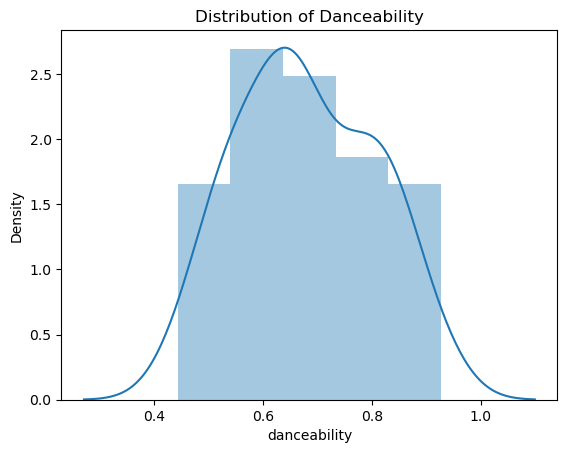

In [138]:
sns.distplot(df['danceability'])
plt.title('Distribution of Danceability')
plt.show()

/var/folders/kb/fxsdzvkd3tn7qtds435g0l880000gn/T/ipykernel_9519/4282887657.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['energy'])


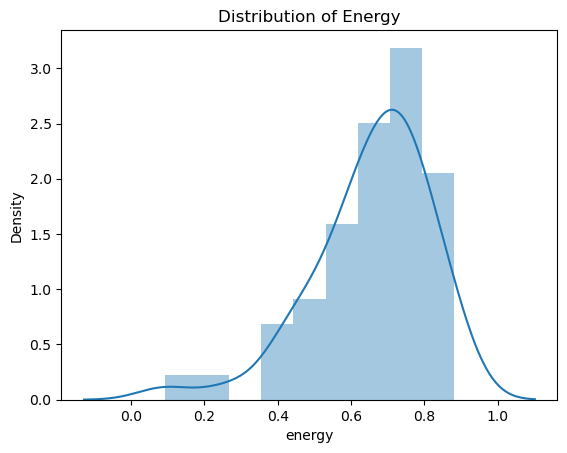

In [139]:
sns.distplot(df['energy'])
plt.title('Distribution of Energy')
plt.show()

In [140]:
sns.distplot(df['loudness'])
plt.title('Distribution of Loudness')
plt.show()

/var/folders/kb/fxsdzvkd3tn7qtds435g0l880000gn/T/ipykernel_9519/51140285.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['loudness'])


In [141]:
sns.distplot(df['speechiness'])
plt.title('Distribution of Speechiness')
plt.show()

/var/folders/kb/fxsdzvkd3tn7qtds435g0l880000gn/T/ipykernel_9519/1634816909.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['speechiness'])


/var/folders/kb/fxsdzvkd3tn7qtds435g0l880000gn/T/ipykernel_9519/4011055723.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['tempo'])


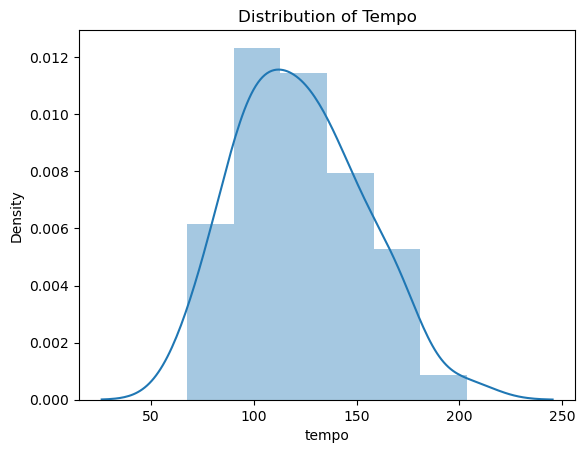

In [142]:
sns.distplot(df['tempo'])
plt.title('Distribution of Tempo')
plt.show()

In [143]:
sns.distplot(df['loudness_to_energy_ratio'])
plt.title('Distribution of Loudness to Energy Ratio')
plt.show()

/var/folders/kb/fxsdzvkd3tn7qtds435g0l880000gn/T/ipykernel_9519/2059923351.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['loudness_to_energy_ratio'])


# Analyzing the Categorical Distributions using Countplots

The self engineered categorical variables give us a better understanding of what makes a hit today. Here are the general trends:

1. Mood: Happy/Energetic
2. Key Mode: 5 Minor
3. Track Type: Vocal
4. Danceability: Medium to High
5. Acoustic Level: Low
6. Tempo Level: Fast to Moderate

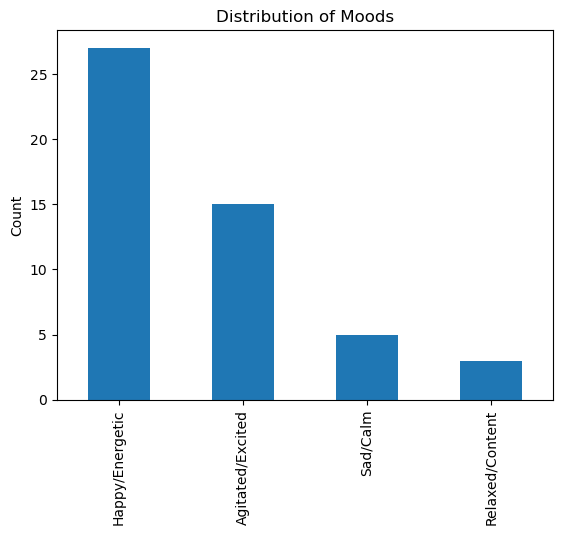

In [144]:
df['mood'] = df['mood'].astype('category')

mood_counts = df['mood'].value_counts()
mood_counts.plot(kind='bar')
plt.title('Distribution of Moods')
plt.ylabel('Count')
plt.show()

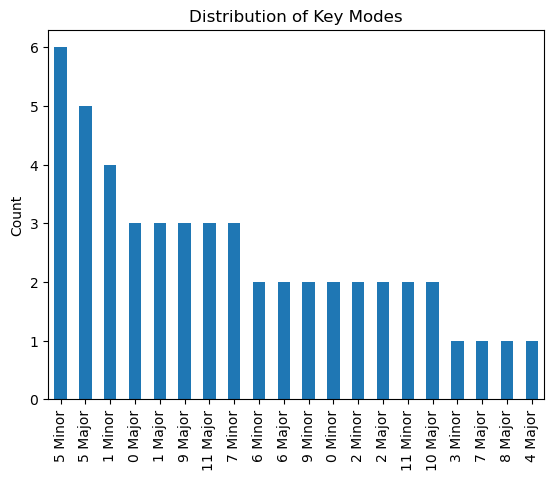

In [145]:
df['key_mode'] = df['key_mode'].astype('category')

mood_counts = df['key_mode'].value_counts()
mood_counts.plot(kind='bar')
plt.title('Distribution of Key Modes')
plt.ylabel('Count')
plt.show()

In [146]:
df['track_type'] = df['track_type'].astype('category')

mood_counts = df['track_type'].value_counts()
mood_counts.plot(kind='bar')
plt.title('Distribution of Track Type')
plt.ylabel('Count')
plt.show()

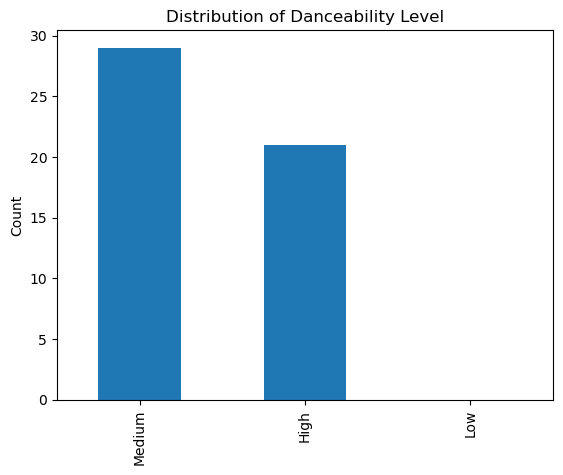

In [147]:
df['danceability_level'] = df['danceability_level'].astype('category')

mood_counts = df['danceability_level'].value_counts()
mood_counts.plot(kind='bar')
plt.title('Distribution of Danceability Level')
plt.ylabel('Count')
plt.show()

In [148]:
df['acoustic_level'] = df['acoustic_level'].astype('category')

mood_counts = df['acoustic_level'].value_counts()
mood_counts.plot(kind='bar')
plt.title('Distribution of Acoustic Level')
plt.ylabel('Count')
plt.show()

In [149]:
df['tempo_category'] = df['tempo_category'].astype('category')

mood_counts = df['tempo_category'].value_counts()
mood_counts.plot(kind='bar')
plt.title('Distribution of Tempo Category')
plt.ylabel('Count')
plt.show()

# Correlation Matrix

Under the correlation matrix for all top 50 songs, we are not seeing anyting that stands out in terms of relationships to the ranking of the song but we are seeing relationships between song variables. 

Besides loudness being correlated with energy and energy to loudness ratio, it's negatively correlated to acousticness which could mean that loud acoustic songs aren't very popular. Energy is also negatively correlated to acousticness. 

I also filtered the dataframe to it's just happy and energetic music and this revealed some interesting results. It was clear that speechiness was negatively correlated to ranking and that was statistically significant given a 90% confidence interval. It was also interesting that liveness was positively correlated to ranking although it was not statistically significant. More data is needed to determine the strenth of the relationship.

This gave me a good understanding of what to look for in the scatterplots.

In [160]:
df['rank'] = df.index + 1

/var/folders/kb/fxsdzvkd3tn7qtds435g0l880000gn/T/ipykernel_9519/2099271658.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


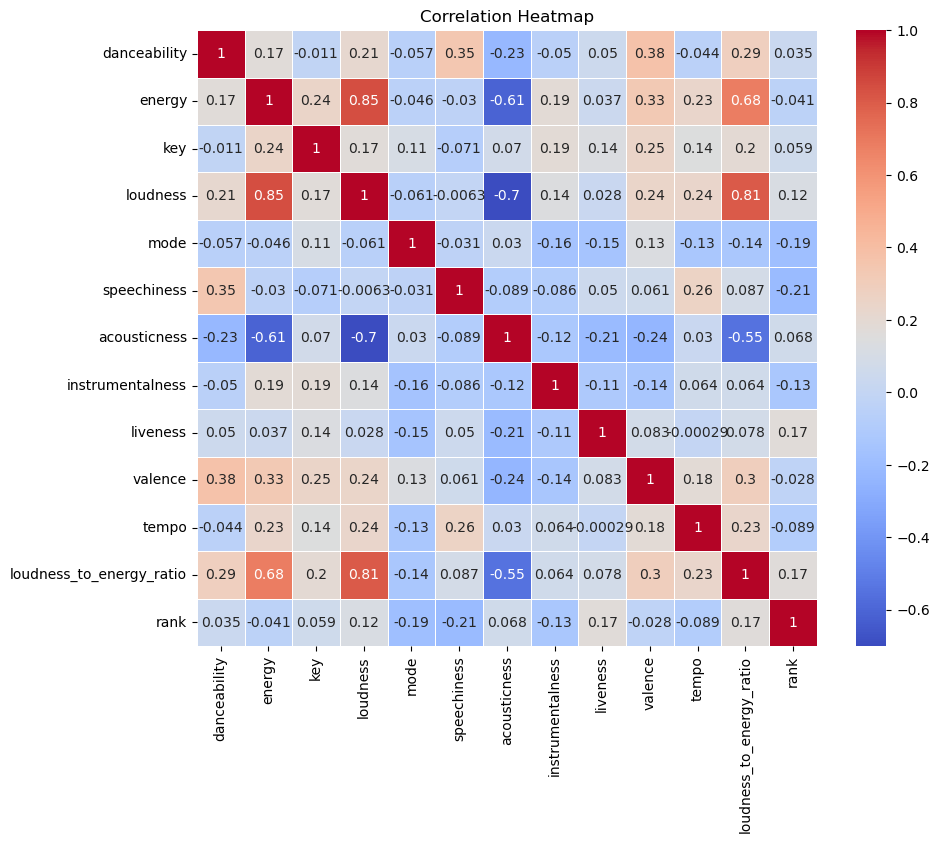

In [166]:
correlation = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", linewidths = .5)
plt.title('Correlation Heatmap')
plt.show()

In [165]:
happy_energetic_df = df[df['mood'] == 'Happy/Energetic']

happy_energetic_correlation = happy_energetic_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(happy_energetic_correlation, annot=True, cmap="coolwarm", linewidths = .5)
plt.title('Correlation Heatmap')
plt.show()

/var/folders/kb/fxsdzvkd3tn7qtds435g0l880000gn/T/ipykernel_9519/3732853187.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  happy_energetic_correlation = happy_energetic_df.corr()


In [169]:
x = happy_energetic_df['speechiness']
y = happy_energetic_df['rank']

r, p = stats.pearsonr(x, y)

print(f'Pearson correlation: {r:.3f}')
print(f'P-value: {p:.3f}')

Pearson correlation: -0.400
P-value: 0.038


In [170]:
x = happy_energetic_df['liveness']
y = happy_energetic_df['rank']

r, p = stats.pearsonr(x, y)

print(f'Pearson correlation: {r:.3f}')
print(f'P-value: {p:.3f}')

Pearson correlation: 0.306
P-value: 0.121


# Comparing Features with Scatterplots

I broke out a couple Scatterplots that showed the ranking bins so we can see if two song feature goals are optimal for making a hit song. The chart reveals a few things:

1. Not too heavy on the instrumentalness
2. In general, it's better to not write songs with too much speechiness, but when it works it works really well. When a song was high in danceability and energy, some of the songs with high speechiness did quite well.
3. Low Acousticness and low liveness songs also seemed to rank highly
4. In general, if you're looking to make it on the charts, the combination you need to optimize for are loudness and energy.

In [250]:
plt.figure(figsize = (8, 8))
sns.scatterplot(data=df, x='danceability', y='speechiness', size='rank', hue='rank', sizes=(20, 200))

plt.title('Danceability vs. Speechiness with Rank as Size')
plt.show()

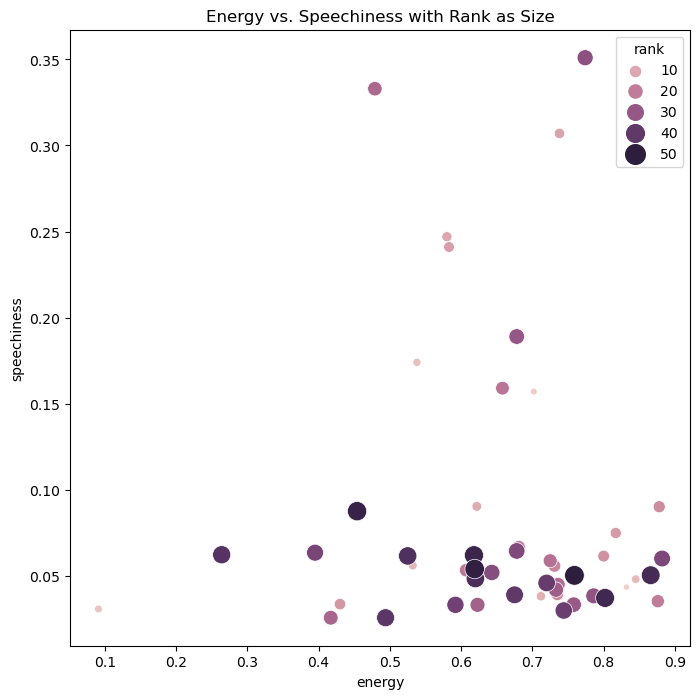

In [206]:
plt.figure(figsize = (8, 8))
sns.scatterplot(data=df, x='energy', y='speechiness', size='rank', hue='rank', sizes=(20, 200))

plt.title('Energy vs. Speechiness with Rank as Size')
plt.show()

In [225]:
plt.figure(figsize = (8, 8))
sns.scatterplot(data=df, x='energy', y='acousticness', size='rank', hue='rank', sizes=(20, 200))

plt.title('Energy vs. Acousticness with Rank as Size')
plt.show()

In [241]:
plt.figure(figsize = (8, 8))
sns.scatterplot(data=df, x='acousticness', y='liveness', size='rank', hue='rank', sizes=(20, 200))

plt.title('Acousticness vs. Liveness with Rank as Size')
plt.show()

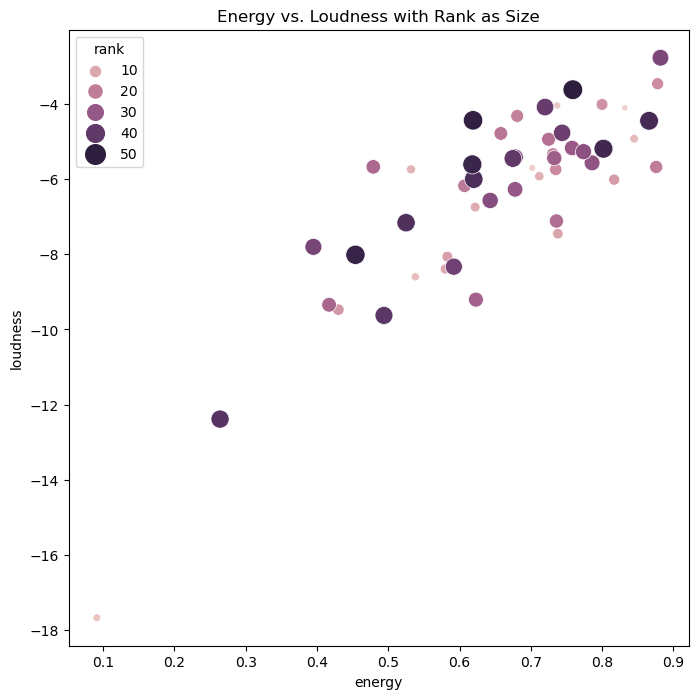

In [253]:
plt.figure(figsize = (8, 8))
sns.scatterplot(data=df, x='energy', y='loudness', size='rank', hue='rank', sizes=(20, 200))

plt.title('Energy vs. Loudness with Rank as Size')
plt.show()

# Conclusion

In the ever-evolving landscape of music, determining the elements that constitute a hit song is a complex endeavor. Through an in-depth exploration of the top 50 songs' features, several key insights have emerged:

Hit songs of today exhibit certain distinct characteristics. Predominantly, they exude a Happy/Energetic mood, suggesting that listeners gravitate towards uplifting tunes. Key Mode 5 in Minor, coupled with a vocal track type, dominates the charts. A song's danceability is vitalâ€”ideally, it should range from medium to high, ensuring that the track resonates with a broad audience looking for rhythm and groove. While being acoustic can add depth to music, the prevailing trend leans towards low acoustic levels, possibly indicating a preference for synthesized or electronic sounds. Moreover, a fast to moderate tempo seems to capture the listeners' hearts, setting the pace for a memorable musical experience.

From a more technical standpoint, it's evident that moderation is key. While certain features like energy, loudness, and danceability should be pronounced, they shouldn't overshadow other elements of the track. Excessively high instrumentalness or speechiness can be detrimental, though there are exceptions. For instance, while high speechiness generally isn't favored, when complemented with optimal danceability and energy, it can create chart-toppers. Furthermore, the negative correlation between loudness and acousticness suggests a potential aversion to loud acoustic tracks. However, it's crucial to remember that trends are transient. What's en vogue today might evolve tomorrow. Therefore, while these insights provide a snapshot of current preferences, the essence of music lies in its unpredictability and the emotional connection it fosters with its audience.